In [ ]:
# Install Kaggle and authenticate
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Select the 'kaggle.json' file downloaded from Kaggle

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aioshichowdhury","key":"c403ded3833a021f35813c9d0325a1f7"}'}

In [ ]:
# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Download the dataset
!kaggle datasets download -d suryaprabhakaran2005/road-accidents-from-cctv-footages-dataset

Dataset URL: https://www.kaggle.com/datasets/suryaprabhakaran2005/road-accidents-from-cctv-footages-dataset
License(s): MIT
 97% 653M/670M [00:04<00:00, 147MB/s]
100% 670M/670M [00:04<00:00, 141MB/s]


In [ ]:
# Unzip the dataset
!unzip road-accidents-from-cctv-footages-dataset.zip -d /content/AccidentDataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/387.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/388.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/389.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/39.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/390.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/391.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/392.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/393.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severity Score Dataset with Labels/1/394.jpg  
  inflating: /content/AccidentDataset/SeverityScore/Severit

In [ ]:
# Required Libraries
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from google.colab import files

In [ ]:
# Dataset Paths
video_data_dir = '/content/AccidentDataset'
accident_dir = os.path.join(video_data_dir, 'Accident','Accident')
non_accident_dir = os.path.join(video_data_dir, 'NonAccident','NonAccident')

In [ ]:
# Image parameters
IMG_SIZE = 128
ColorChannels = 3

In [ ]:
# Function to convert videos to frames
def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    frames = []
    while vidcap.isOpened():
        success, image = vidcap.read()
        if not success:
            break
        resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        frames.append(resized)
    vidcap.release()
    return frames

In [ ]:
# Function to load category videos
def load_category_videos(category_dir, class_num):
    X_data = []
    y_data = []
    for video in tqdm(os.listdir(category_dir)):
        video_path = os.path.join(category_dir, video)
        frames = video_to_frames(video_path)
        for frame in frames:
            X_data.append(frame)
            y_data.append(class_num)
    return X_data, y_data

In [ ]:
# Load Accident and Non-Accident data
X_accident, y_accident = load_category_videos(accident_dir, 1)
X_non_accident, y_non_accident = load_category_videos(non_accident_dir, 0)

100%|██████████| 7710/7710 [00:08<00:00, 894.57it/s]


In [ ]:
# Combine accident and non-accident data
X_data = np.array(X_accident + X_non_accident).reshape(-1, IMG_SIZE, IMG_SIZE, ColorChannels)
y_data = np.array(y_accident + y_non_accident)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

In [ ]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
# Define the AlexNet Model
def create_alexnet_model():
    model = Sequential()

    # Layer 1: Convolution + MaxPooling
    model.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, ColorChannels)))
    model.add(MaxPooling2D((3, 3), strides=2))

    # Layer 2: Convolution + MaxPooling
    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=2))

    # Layer 3: Convolution Layers
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((3, 3), strides=2))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_alexnet_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         1

In [ ]:
# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("accident_detection_alexnet.keras", monitor="val_loss", save_best_only=True)
]

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/5
348/348 [==============================] - 618s 2s/step - loss: 0.6889 - accuracy: 0.5489 - val_loss: 0.6872 - val_accuracy: 0.5545
Epoch 2/5
348/348 [==============================] - 615s 2s/step - loss: 0.6875 - accuracy: 0.5547 - val_loss: 0.6884 - val_accuracy: 0.5545
Epoch 3/5
348/348 [==============================] - 615s 2s/step - loss: 0.6881 - accuracy: 0.5547 - val_loss: 0.6880 - val_accuracy: 0.5545
Epoch 4/5
348/348 [==============================] - 614s 2s/step - loss: 0.6875 - accuracy: 0.5547 - val_loss: 0.6872 - val_accuracy: 0.5545
Epoch 5/5
348/348 [==============================] - 616s 2s/step - loss: 0.6877 - accuracy: 0.5547 - val_loss: 0.6876 - val_accuracy: 0.5545


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


87/87 [==============================] - 31s 356ms/step - loss: 0.6876 - accuracy: 0.5545
Test Loss: 0.6875994801521301
Test Accuracy: 0.554476797580719


In [ ]:
# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

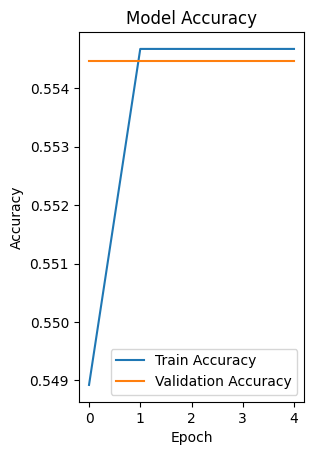

In [ ]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

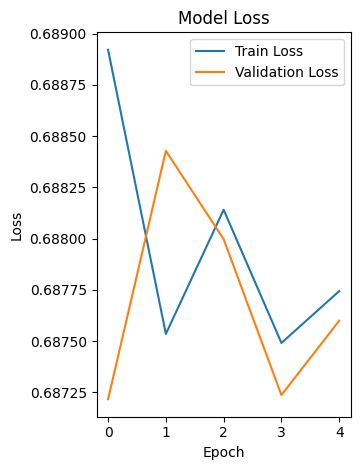

In [ ]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Predict on the test set for confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Convert probabilities to binary predictions (0 or 1)

87/87 [==============================] - 31s 355ms/step


In [ ]:
# Predict on the test set for confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels (0 or 1)

# Convert one-hot encoded y_test to binary labels if necessary
y_test = np.argmax(y_test, axis=1)  # Convert to binary labels (0 or 1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

87/87 [==============================] - 31s 360ms/step


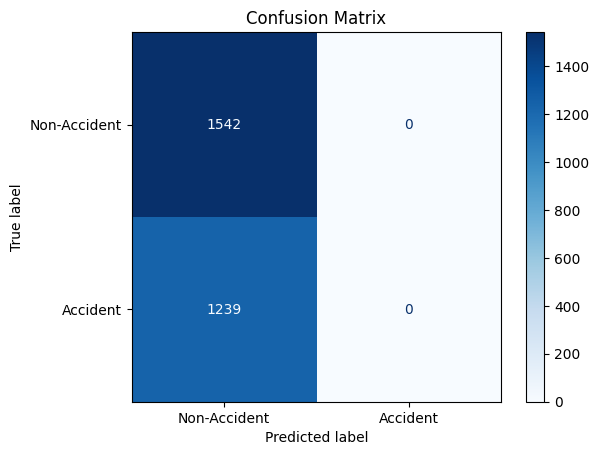

In [ ]:
# Display the confusion matrix
# Define the class labels
CLASSES = ['Non-Accident', 'Accident']  # Replace with your actual class names if different

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Save the model
model.save("accident_detection_alexnet.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
